In [1]:
# Import core packages
import scanpy as sc
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import geopandas as gpd
from matplotlib.patches import Polygon
import seaborn as sns

# Disable annoying warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# set working directory
import os
os.chdir('/home/renpf/course/computation_immune/')

# Direct show figure in jupyter
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Analysis and visualization of spatial transcriptomics data

This tutorial demonstrates how to work with spatial transcriptomics data within Scanpy

Pengfei Ren (pfren@stu.pku.edu.cn), Zexian Zeng(zexianzeng@pku.edu.cn)

Center for Quantitative Biology

Academy for Advanced Interdisciplinary Studies, Peking University

Lab website: http://cqb.pku.edu.cn/zenglab/

## Load conda environment


source /lustre1/share/miniconda3/bin/activate

conda activate spatial


## Run spaceranger

spaceranger count \
    --id=HD \
    --transcriptome=/home/apps/spaceranger-3.0.0/refGenome/geneEx-h38  \
    --probe-set=/home/apps/spaceranger-3.0.0/probe_sets/Visium_Human_Transcriptome_Probe_Set_v2.0_GRCh38-2020-A.csv \
    --fastqs=/home/renpf/course/computation_immune/hd_fastq/ \
    --cytaimage=/home/renpf/course/computation_immune/hd_fastq/CAVG10527_2024-07-17_13-14-05_2024-07-17_13-02-12_H1-B4Z6TMT_A1_20240709-COLON.tif\
    --image=/home/renpf/course/computation_immune/hd_fastq/20240709-COLON_cut.tif \
    --slidefile=/home/renpf/course/computation_immune/hd_fastq/H1-B4Z6TMT.vlf \
    --loupe-alignment=/home/renpf/course/computation_immune/hd_fastq/H1-B4Z6TMT-A1-fiducials-image-registration.json \
    --create-bam=false \
    --localcores=16 \
    --output-dir=/home/renpf/course/computation_immune/hd_fastq/spaceranger_output/

## Reading the data
We will use a Visium HD spatial transcriptomics dataset of the colon cancer. The dataset will be stored in an `AnnData` object. AnnData is a popular format for storing spatial transcriptomics data used by scanpy. It allows for a comprenhensive and scalable storage of data matrix, annotation information and images on different layers.

![jupyter](images/anndata.svg)

### bin-based output

In [2]:
# load data from spaceranger output
adata = sc.read_10x_h5('spaceranger_output/outs/binned_outputs/square_008um/filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

In [3]:
adata = sc.read_h5ad('hd.adata')

In [4]:
# load coordinates for each 8-um bin
coords = pd.read_parquet('spaceranger_output/outs/binned_outputs/square_008um/spatial/tissue_positions.parquet')
coords.index = coords['barcode']
coords = coords.drop(columns='barcode')
coords.columns = ["in_tissue", "array_row", "array_col", "pxl_col_in_fullres", "pxl_row_in_fullres"]
# add the spatial coordinates to the adata object
adata.obs = pd.merge(adata.obs, coords, how="left", left_index=True, right_index=True)
adata.obsm['spatial'] = adata.obs[["pxl_row_in_fullres", "pxl_col_in_fullres"]].values

In [5]:
# add H&E image and scalefactors to the adata object
img = np.array(Image.open("spaceranger_output/outs/binned_outputs/square_008um/spatial/tissue_hires_image.png"))
adata.uns['spatial'] = {
    "HD": {
        "images": {
            "hires": img
        }
    }
}
adata.uns['spatial']['HD']['scalefactors'] = json.loads(Path('spaceranger_output/outs/binned_outputs/square_008um/spatial/scalefactors_json.json').read_bytes())

In [6]:
adata

AnnData object with n_obs × n_vars = 3728 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [7]:
# gene names
adata.var_names

Index(['SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'HES4', 'ISG15',
       'AGRN', 'RNF223', 'C1orf159',
       ...
       'MT-ND2', 'MT-CO2', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', length=18085)

In [8]:
# Properties of each gene
adata.var.head()

gene_ids    feature_types  genome
SAMD11   ENSG00000187634  Gene Expression  GRCh38
NOC2L    ENSG00000188976  Gene Expression  GRCh38
KLHL17   ENSG00000187961  Gene Expression  GRCh38
PLEKHN1  ENSG00000187583  Gene Expression  GRCh38
PERM1    ENSG00000187642  Gene Expression  GRCh38

In [9]:
# cell names
adata.obs_names

Index(['s_008um_00431_00553-1', 's_008um_00388_00571-1',
       's_008um_00431_00538-1', 's_008um_00401_00559-1',
       's_008um_00395_00590-1', 's_008um_00398_00574-1',
       's_008um_00418_00581-1', 's_008um_00403_00587-1',
       's_008um_00401_00561-1', 's_008um_00431_00565-1',
       ...
       's_008um_00410_00553-1', 's_008um_00427_00590-1',
       's_008um_00427_00558-1', 's_008um_00402_00534-1',
       's_008um_00415_00570-1', 's_008um_00388_00531-1',
       's_008um_00417_00534-1', 's_008um_00398_00554-1',
       's_008um_00420_00591-1', 's_008um_00401_00587-1'],
      dtype='object', length=3728)

In [10]:
# Properties of each cell
adata.obs.head()

in_tissue  array_row  array_col  pxl_col_in_fullres  \
s_008um_00431_00553-1          1        431        553        15162.658940   
s_008um_00388_00571-1          1        388        571        13862.367997   
s_008um_00431_00538-1          1        431        538        15152.984585   
s_008um_00401_00559-1          1        401        559        14251.249596   
s_008um_00395_00590-1          1        395        590        14088.189012   

                       pxl_row_in_fullres  
s_008um_00431_00553-1        14530.071821  
s_008um_00388_00571-1        13953.080252  
s_008um_00431_00538-1        14987.752092  
s_008um_00401_00559-1        14327.621814  
s_008um_00395_00590-1        13377.874740

In [11]:
# coordinates of each cell
adata.obsm['spatial']

array([[14530.07182113, 15162.65893961],
       [13953.08025188, 13862.36799671],
       [14987.75209191, 15152.98458452],
       ...,
       [14478.24420188, 14156.49641275],
       [13363.51278335, 14851.56594924],
       [13473.2864866 , 14269.30987642]])

In [12]:
adata.uns

OrderedDict([('spatial',
              {'HD': {'images': {'hires': array([[[249, 249, 249],
                         [249, 249, 249],
                         [249, 249, 249],
                         ...,
                         [249, 249, 249],
                         [249, 249, 249],
                         [249, 249, 249]],
                 
                        [[249, 249, 249],
                         [249, 249, 249],
                         [249, 249, 249],
                         ...,
                         [249, 249, 249],
                         [249, 249, 249],
                         [250, 250, 250]],
                 
                        [[249, 249, 249],
                         [250, 250, 250],
                         [250, 250, 250],
                         ...,
                         [249, 249, 249],
                         [249, 249, 249],
                         [250, 250, 250]],
                 
                        ...,
                 


### cell segmentation

In [13]:
# load cell segmentation results
gdf = gpd.read_file(f"spaceranger_output/outs/segmented_outputs/cell_segmentations.geojson")
gdf["centroid_x"] = gdf.centroid.x
gdf["centroid_y"] = gdf.centroid.y

ERROR 1: PROJ: proj_create_from_database: Open of /home/renpf/anaconda3/envs/spatial/share/proj failed


In [14]:
# each row represents a cell, and the geometry column contains the polygon of the cell
gdf.head()

cell_id                                           geometry   centroid_x  \
0        1  POLYGON ((6152.8 3367, 6153 3374.6, 6160.6 337...  6152.012531   
1        4  POLYGON ((6721 3171.8, 6721.2 3179.5, 6736.5 3...  6707.581008   
2        5  POLYGON ((6515.2 3542.5, 6515.5 3557.7, 6523.2...  6507.754270   
3        6  POLYGON ((5925.1 3425.3, 5925.4 3440.5, 5933.1...  5899.955262   
4        8  POLYGON ((7444.1 3080.2, 7444.4 3095.5, 7452 3...  7425.427191   

    centroid_y  
0  3395.882344  
1  3213.543074  
2  3566.161725  
3  3456.131310  
4  3100.016048

In [15]:
print(gdf.loc[0,'geometry'])

POLYGON ((6152.8 3367, 6153 3374.6, 6160.6 3374.5, 6160.8 3382.1, 6168.4 3381.9, 6168.6 3389.6, 6176.2 3389.4, 6176.3 3397, 6184 3396.9, 6184.1 3404.5, 6176.5 3404.7, 6176.7 3412.3, 6161.4 3412.6, 6161.6 3420.2, 6146.3 3420.6, 6146.2 3412.9, 6130.9 3413.3, 6130.7 3405.6, 6123.1 3405.8, 6123 3398.2, 6130.6 3398, 6130.3 3382.8, 6137.9 3382.6, 6137.6 3367.3, 6152.8 3367))


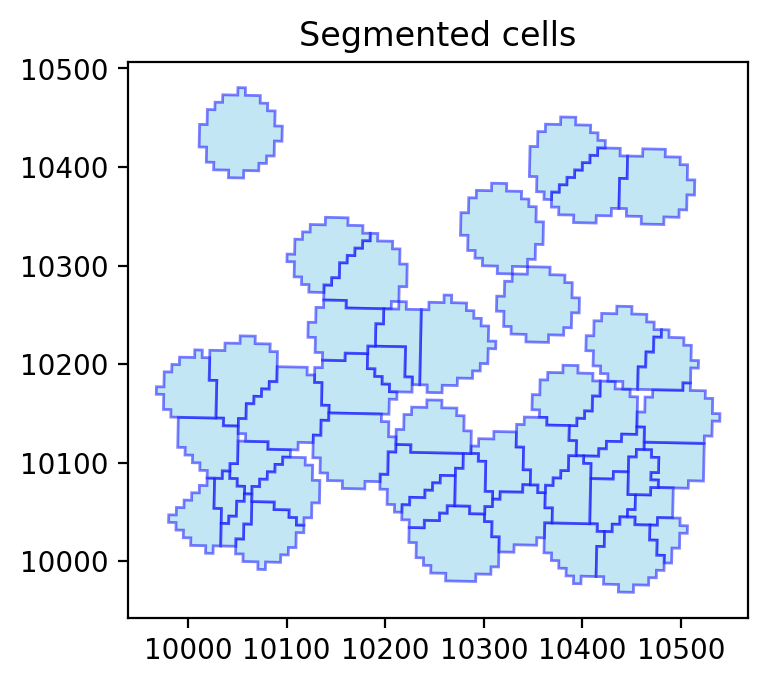

In [16]:
gdf_subset = gdf[ (gdf['centroid_x'] >= 10000) & (gdf['centroid_x'] <= 10500) &
    (gdf['centroid_y'] >= 10000) & (gdf['centroid_y'] <= 10500)]
fig, ax = plt.subplots(figsize=(4, 4))
for geom in gdf_subset.geometry:
    coords = list(geom.exterior.coords)
    patch = Polygon(coords, closed=True, facecolor='skyblue', edgecolor='blue', alpha=0.5)
    ax.add_patch(patch)
ax.set_aspect('equal')
ax.autoscale_view()
ax.set_title('Segmented cells')
plt.show()

## QC and preprocessing

In [17]:
# standards QC metrics with pp.calculate_qc_metrics and percentage of mitochondrial genes per sample.
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

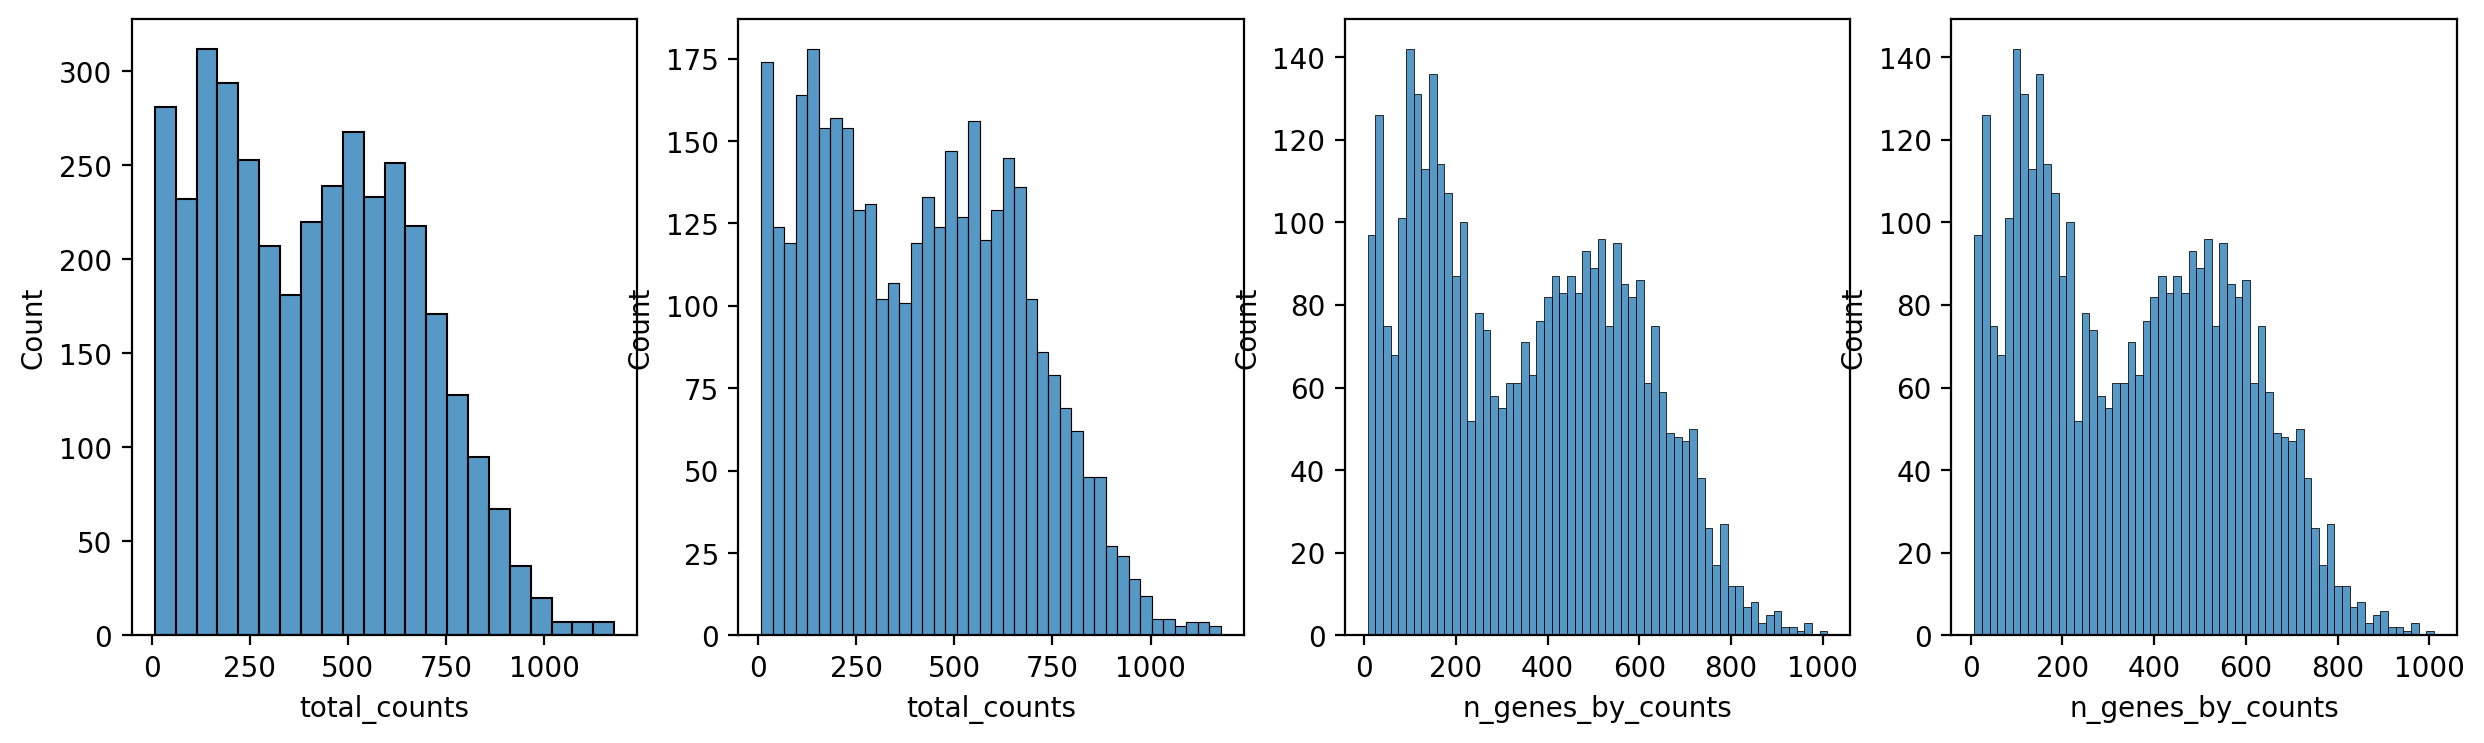

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [19]:
# perform some basic filtering of spots based on total counts and expressed genes
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs["pct_counts_mt"] < 10].copy()

In [20]:
# proceed to normalize Visium counts data with the built-in normalize_total method from Scanpy, and detect highly-variable genes
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

## Clustering and annotation

In [21]:
# reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.pp.pca(adata)
# compute the neighborhood graph of cells using the PCA representation of the data matrix
sc.pp.neighbors(adata)
# embedding the graph in two dimensions using UMAP
sc.tl.umap(adata)
# leiden clustering
sc.tl.leiden(
    adata, key_added="clusters", n_iterations=2, resolution=0.2
)

/home/renpf/anaconda3/envs/spatial/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-01 15:38:04.391843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 15:38:04.533721: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 15:38:04.537285: W tensorflow/compiler/xla/stream_executor/platfo

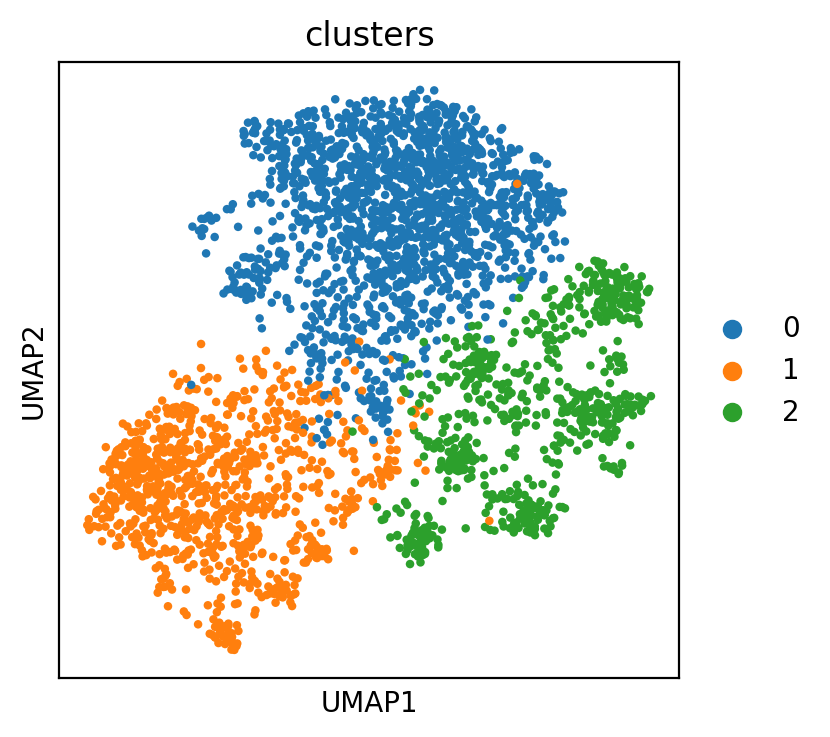

In [22]:
# plot the clusters
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["clusters"], wspace=0.4)

In [23]:
# compute a ranking for the highly differential genes in each cluster.
sc.tl.rank_genes_groups(
    adata,
    groupby='clusters',  
    method='wilcoxon',   
    pts=True             
)

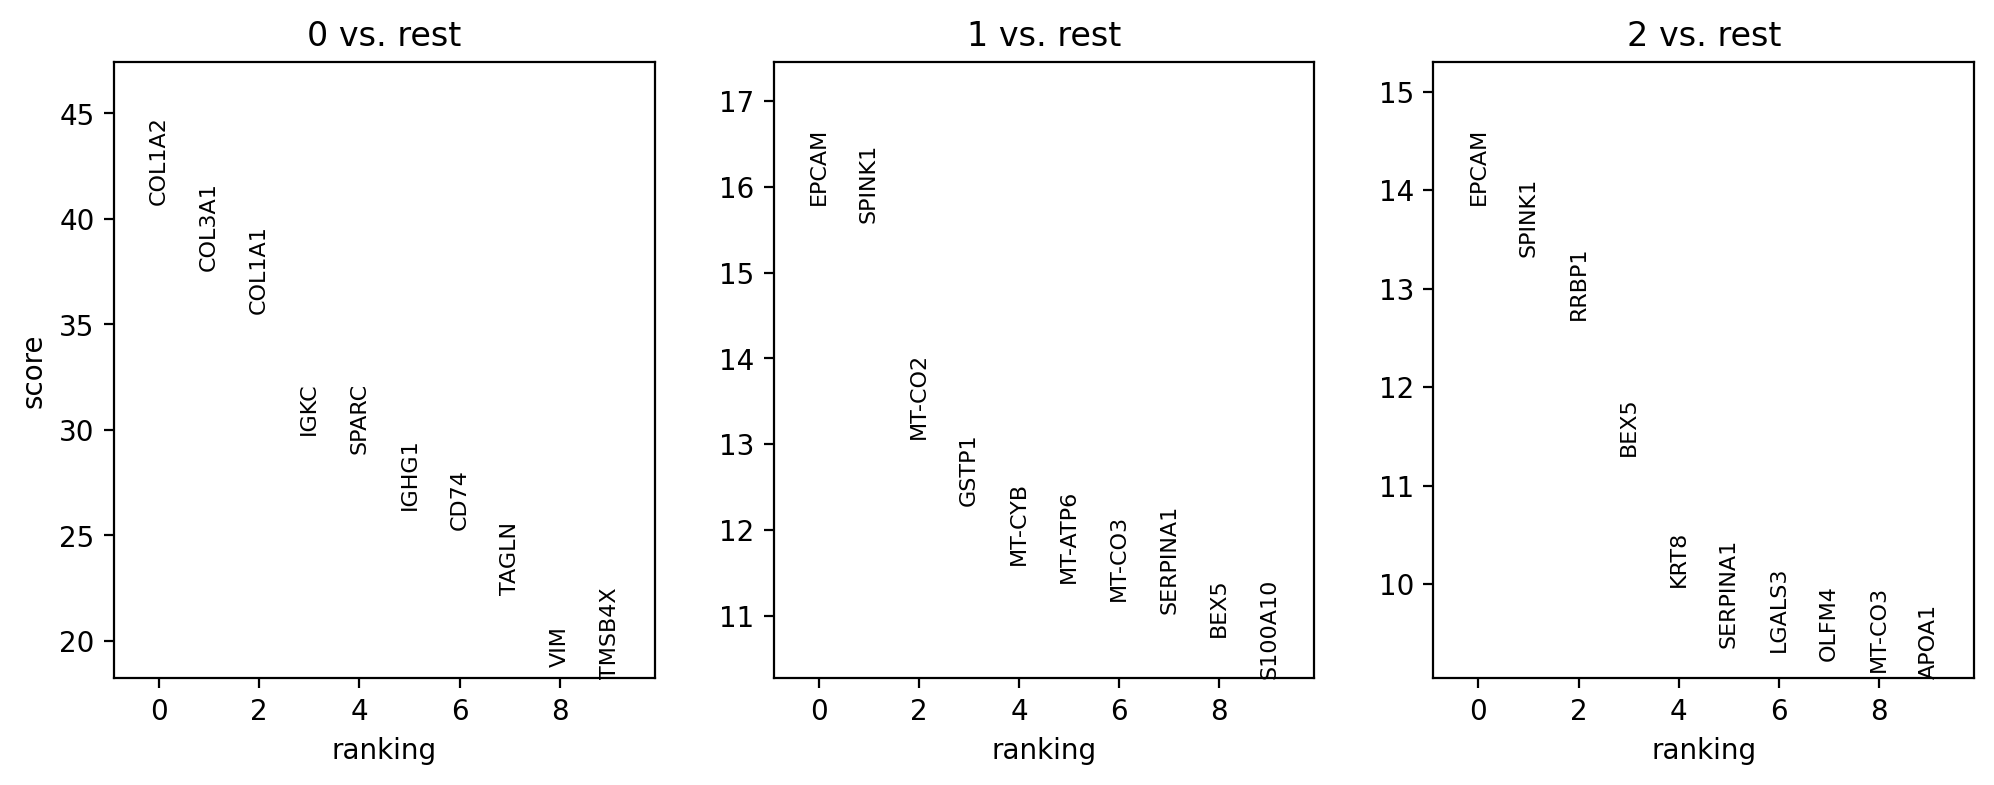

In [24]:
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [25]:
# assign cell types for each cluster
adata.obs['cell_type'] = adata.obs['clusters'].map({
    '0': 'Fibroblast',
    '1': 'Epithelial',
    '2': 'Epithelial'
})

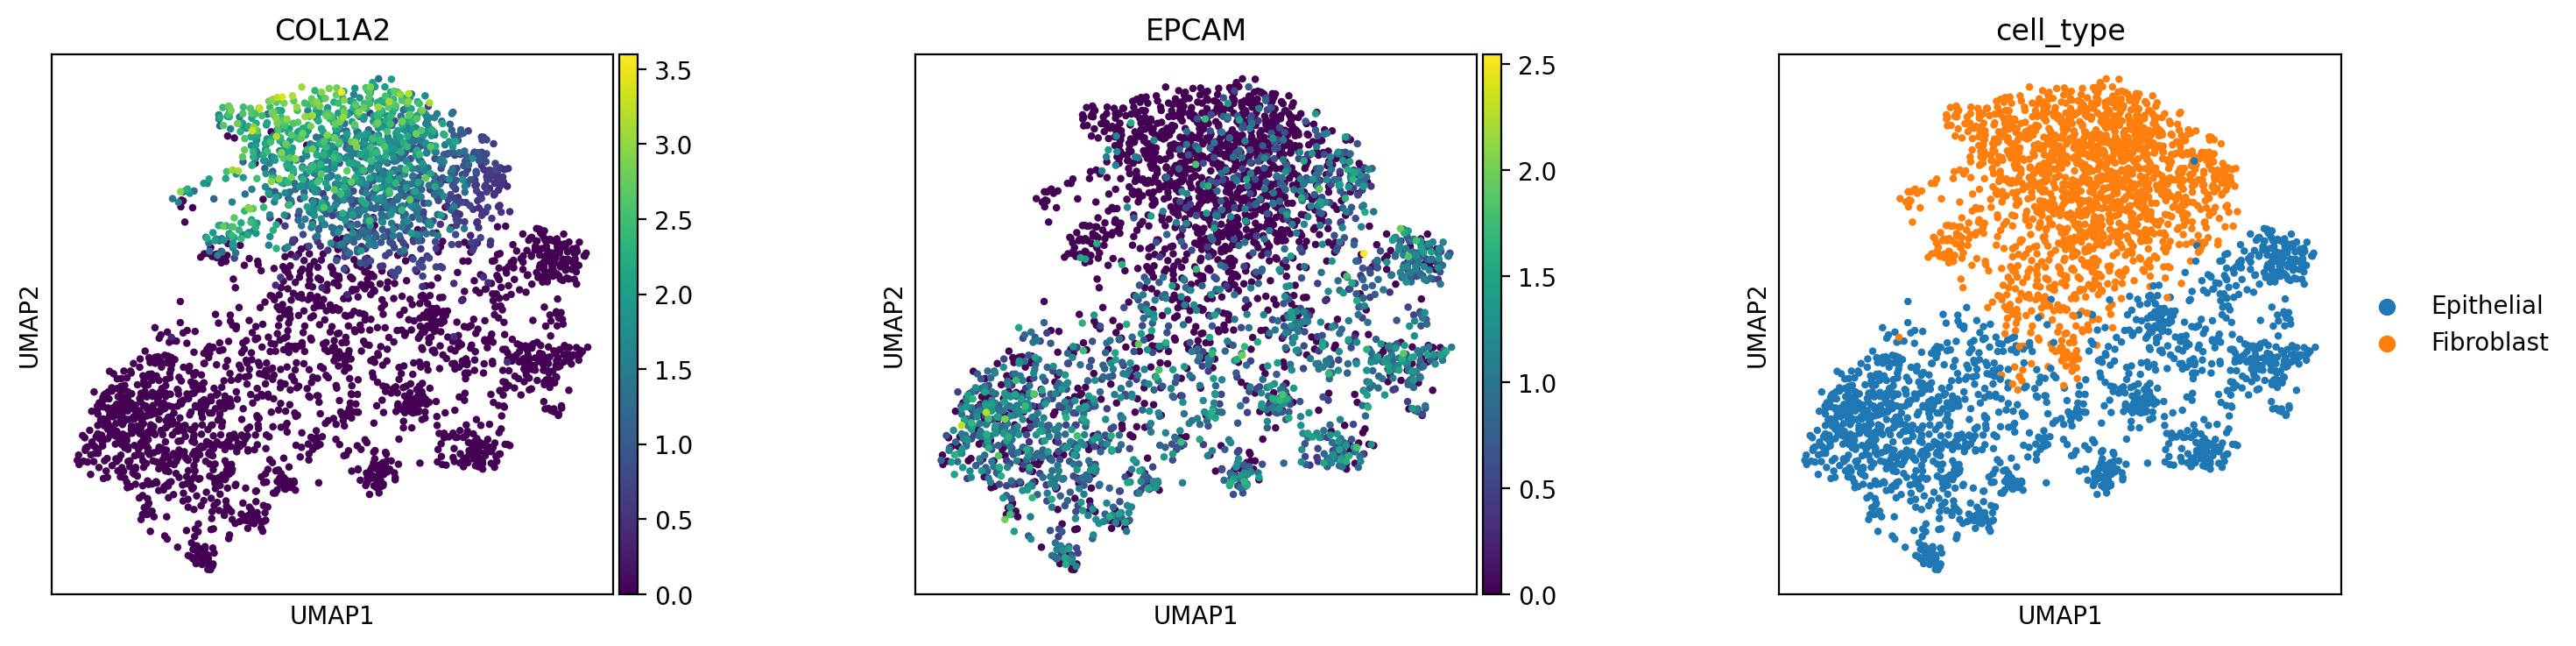

In [26]:
# check the expression of COL1A2 and EPCAM across cells
sc.pl.umap(adata, color=["COL1A2","EPCAM","cell_type"], wspace=0.4)

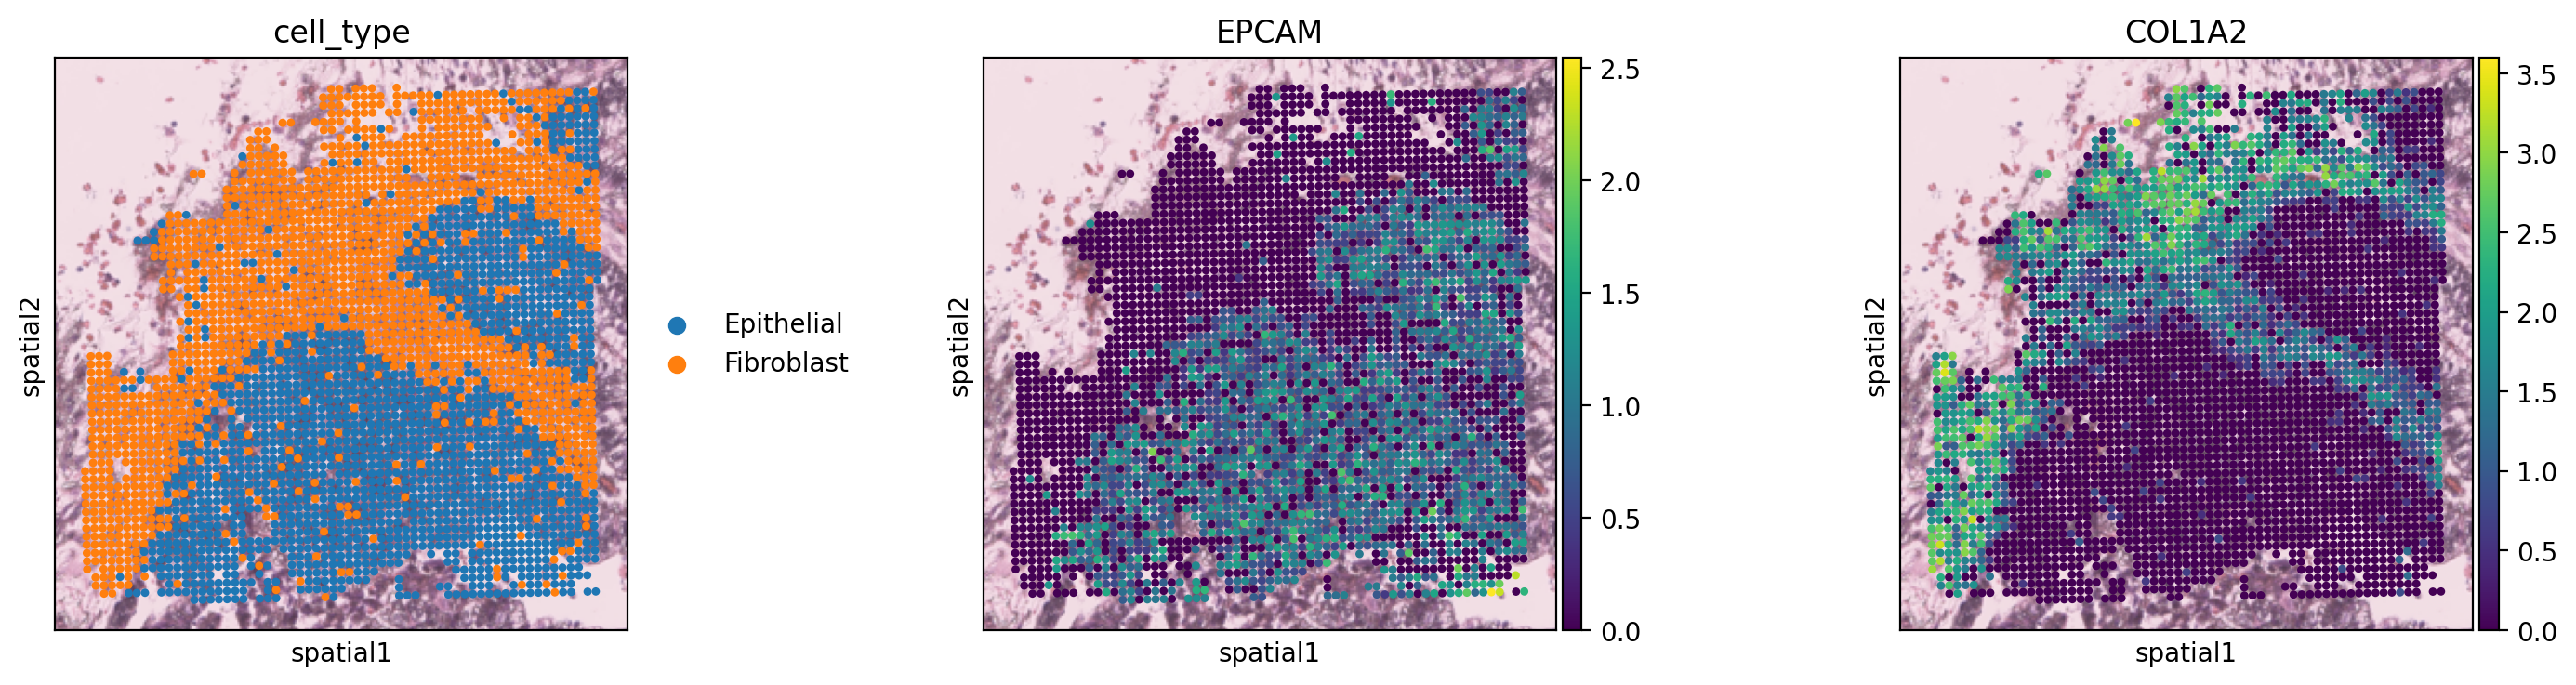

In [27]:
# we will overlay the spots on top of the Hematoxylin and eosin stain (H&E) image to see how the cell types are spatially organized, using the function sc.pl.spatial
sc.pl.spatial(adata, img_key="hires", color=["cell_type", "EPCAM", "COL1A2"], wspace=0.4)

In [28]:
# clustering resolution (granularity) in single-cell analysis controls how finely or coarsely the cells are grouped into clusters.
sc.tl.leiden(
    adata, key_added="clusters", n_iterations=2, resolution = 0.6
)

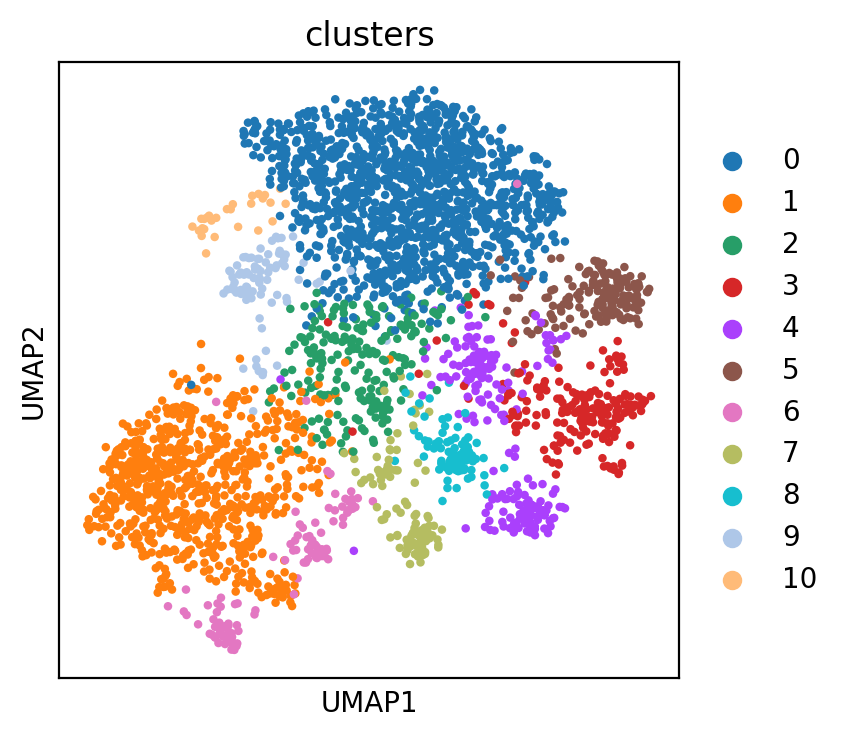

In [29]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["clusters"], wspace=0.4)

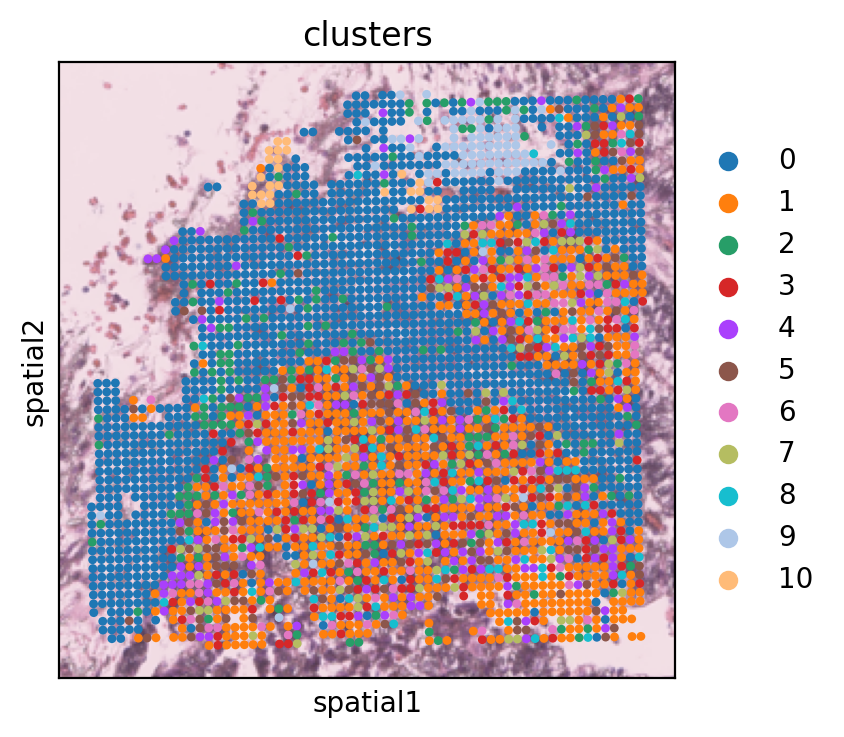

In [30]:
sc.pl.spatial(adata, img_key="hires", color=["clusters"])